In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt



In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [6]:
!tar -xf lfw.tgz

In [7]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [8]:
import uuid

In [9]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\e0ca29aa-a38b-11ed-940c-86013b79a7a6.jpg'

In [10]:
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    cv2.imshow('Image Collection', frame)
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

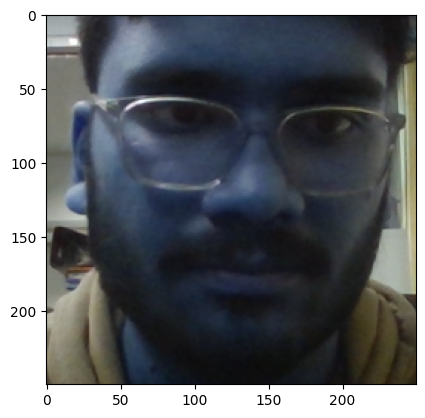

In [11]:
plt.imshow(frame)

In [12]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [13]:
dir_test = anchor.as_numpy_iterator()

In [14]:
print(dir_test.next())

b'data\\anchor\\dd77e0d7-a384-11ed-bffe-8569b4591318.jpg'


In [15]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

In [16]:
img = preprocess('data\\anchor\\9f54df84-a315-11ed-a7a6-cd6b7707af2d.jpg')

In [17]:
img.numpy().max() 

0.9823529

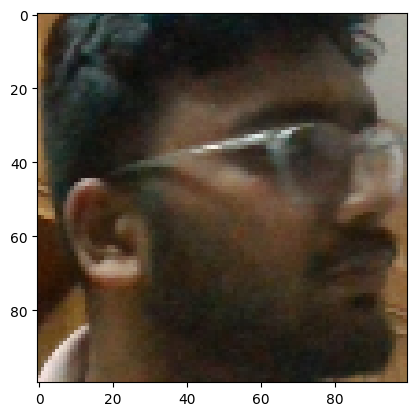

In [18]:
plt.imshow(img)


In [19]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [20]:
samples = data.as_numpy_iterator()

In [21]:
exampple = samples.next()

In [22]:
exampple


(b'data\\anchor\\9cd62536-a315-11ed-8829-cd6b7707af2d.jpg',
 b'data\\positive\\b913a661-a315-11ed-a3cb-cd6b7707af2d.jpg',
 1.0)

In [23]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [24]:
res = preprocess_twin(*exampple)

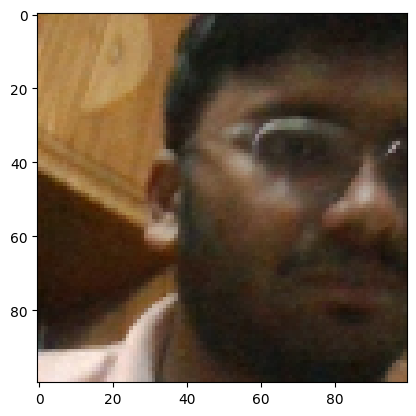

In [28]:
plt.imshow(res[0])

In [29]:
res[2]

1.0

In [30]:

data = data.cache()
data = data.shuffle(buffer_size=10000)


In [31]:
data = data.map(preprocess_twin)


In [32]:

train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [33]:
round(len(data)*0.7)

571

In [34]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [35]:
inp = Input(shape=(100,100,3), name='input_image')

In [36]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [37]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [38]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [39]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [40]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [41]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [42]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [43]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [44]:
embedding = make_embedding()

In [45]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [46]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [47]:
l1 = L1Dist()

In [48]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [49]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [50]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [51]:
siamese_layer = L1Dist()

In [52]:
distances = siamese_layer(inp_embedding, val_embedding)

In [53]:
classifier = Dense(1, activation='sigmoid')(distances)

In [54]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [55]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [56]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [57]:
def make_siamese_model(): 
    input_image = Input(name='input_img', shape=(100,100,3))
    validation_image = Input(name='validation_img', shape=(100,100,3))
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [58]:
siamese_model = make_siamese_model()

In [59]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [60]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [61]:
opt = tf.keras.optimizers.Adam(1e-4) 

In [62]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [63]:
test_batch = train_data.as_numpy_iterator()

In [64]:
batch_1 = test_batch.next()

In [65]:
X = batch_1[:2]

In [66]:
y = batch_1[2]

In [67]:
tf.losses.BinaryCrossentropy

keras.losses.BinaryCrossentropy

In [68]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:     
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

In [69]:
from tensorflow.keras.metrics import Precision, Recall

In [70]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        r = Recall()
        p = Precision()
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [71]:
EPOCHS = 10

In [72]:
print(EPOCHS)

10


In [73]:
train(train_data, EPOCHS)



 Epoch 1/10
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
36/36 [==============================] - 951s 27s/step
0.14881702 0.6197183 0.88

 Epoch 2/10
36/36 [==============================] - 958s 26s/step
0.04110163 0.90547264 0.962963

 Epoch 3/10
36/36 [==============================] - 1036s 29s/step
0.022930633 0.95412844 0.97652584

 Epoch 4/10
36/36 [==============================] - 1137s 32s/step
0.07988771 0.98550725 1.0

 Epoch 5/10
36/36 [==============================] - 1105s 31s/step
0.24284844 1.0 1.0

 Epoch 6/10
36/36 [==============================] - 931s 26s/step
0.002368541 0.98578197 1.0

 Epoch 7/10
36/36 [==============================] - 981s 27s/step
0.0040852996 0.9809524 0.9951691

 Epoch 8/10
36/36 [==============================] - 942s 26s/step
0.008055176 1.0 1.0

 Epoch 9/10
36/36 [==============================] - 1018s 28s/step
0.06290969 0.9

In [74]:
from tensorflow.keras.metrics import Precision, Recall


In [75]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()


In [76]:
y_hat = siamese_model.predict([test_input, test_val])


1/1 [==============================] - 1s 1s/step


In [77]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]


[1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1]

In [78]:
y_true


array([1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

In [79]:
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [80]:
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [81]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 1s 829ms/step
1.0 1.0


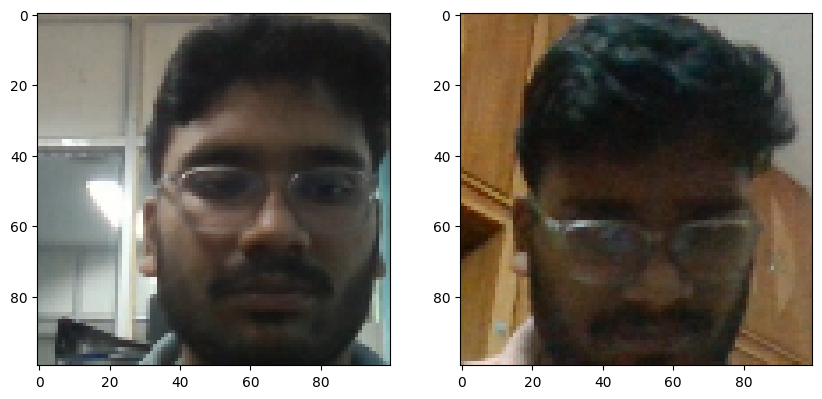

In [82]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])
plt.subplot(1,2,2)
plt.imshow(test_val[0])
plt.show()

In [83]:
siamese_model.save('siamesemodelv2.h5')

In [84]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [85]:
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 1s 597ms/step


array([[9.9994349e-01],
       [1.8074637e-06],
       [9.6649295e-01],
       [9.9780995e-01],
       [9.9926770e-01]], dtype=float32)

In [86]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [87]:
os.listdir(os.path.join('application_data', 'verification_images'))


['b20b261a-a315-11ed-ac74-cd6b7707af2d.jpg',
 'b20fedf2-a315-11ed-ab60-cd6b7707af2d.jpg',
 'b2198344-a315-11ed-9c5a-cd6b7707af2d.jpg',
 'b26c355c-a315-11ed-86d9-cd6b7707af2d.jpg',
 'b270fb76-a315-11ed-924e-cd6b7707af2d.jpg',
 'b275b1d1-a315-11ed-bf4f-cd6b7707af2d.jpg',
 'b2904782-a315-11ed-84cc-cd6b7707af2d.jpg',
 'b299c08f-a315-11ed-88f6-cd6b7707af2d.jpg',
 'b36d9078-a315-11ed-b758-cd6b7707af2d.jpg',
 'b4080044-a315-11ed-8c6f-cd6b7707af2d.jpg',
 'b41b4bd6-a315-11ed-86c5-cd6b7707af2d.jpg',
 'b4845914-a315-11ed-942e-cd6b7707af2d.jpg',
 'b52105d3-a315-11ed-9803-cd6b7707af2d.jpg',
 'b533fc58-a315-11ed-a023-cd6b7707af2d.jpg',
 'b538bca5-a315-11ed-ba0e-cd6b7707af2d.jpg',
 'b54231a4-a315-11ed-ad07-cd6b7707af2d.jpg',
 'b546c4a9-a315-11ed-96e8-cd6b7707af2d.jpg',
 'b55717db-a315-11ed-abed-cd6b7707af2d.jpg',
 'b57d8f33-a315-11ed-8b90-cd6b7707af2d.jpg',
 'b58bd41f-a315-11ed-a828-cd6b7707af2d.jpg',
 'b5907132-a315-11ed-a79c-cd6b7707af2d.jpg',
 'b61a3aed-a315-11ed-bddf-cd6b7707af2d.jpg',
 'b6261307

In [88]:
os.path.join('application_data', 'input_image', 'input_image.jpg')


'application_data\\input_image\\input_image.jpg'

In [89]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\b20b261a-a315-11ed-ac74-cd6b7707af2d.jpg
application_data\verification_images\b20fedf2-a315-11ed-ab60-cd6b7707af2d.jpg
application_data\verification_images\b2198344-a315-11ed-9c5a-cd6b7707af2d.jpg
application_data\verification_images\b26c355c-a315-11ed-86d9-cd6b7707af2d.jpg
application_data\verification_images\b270fb76-a315-11ed-924e-cd6b7707af2d.jpg
application_data\verification_images\b275b1d1-a315-11ed-bf4f-cd6b7707af2d.jpg
application_data\verification_images\b2904782-a315-11ed-84cc-cd6b7707af2d.jpg
application_data\verification_images\b299c08f-a315-11ed-88f6-cd6b7707af2d.jpg
application_data\verification_images\b36d9078-a315-11ed-b758-cd6b7707af2d.jpg
application_data\verification_images\b4080044-a315-11ed-8c6f-cd6b7707af2d.jpg
application_data\verification_images\b41b4bd6-a315-11ed-86c5-cd6b7707af2d.jpg
application_data\verification_images\b4845914-a315-11ed-942e-cd6b7707af2d.jpg
application_data\verification_images\b52105d3-a315-11ed-9803-cd6

In [90]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    return results, verified

In [91]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 251ms/step
True
1/1 [==============================] - 0s 374ms/step
True
1/1 [==============================] - 0s 368ms/step
True
1/1 [==============================] - 0s 315ms/step
False


In [94]:
np.sum(np.squeeze(results) > 0.4)


2

In [95]:
results


[array([[0.0064218]], dtype=float32),
 array([[0.00702761]], dtype=float32),
 array([[0.00895339]], dtype=float32),
 array([[0.22918974]], dtype=float32),
 array([[0.2543773]], dtype=float32),
 array([[0.51207]], dtype=float32),
 array([[0.11086368]], dtype=float32),
 array([[0.16310614]], dtype=float32),
 array([[0.00859428]], dtype=float32),
 array([[0.04474639]], dtype=float32),
 array([[0.02873165]], dtype=float32),
 array([[0.02427147]], dtype=float32),
 array([[0.03035129]], dtype=float32),
 array([[0.02225518]], dtype=float32),
 array([[0.01749919]], dtype=float32),
 array([[0.0750597]], dtype=float32),
 array([[0.05451621]], dtype=float32),
 array([[0.04716681]], dtype=float32),
 array([[0.03115756]], dtype=float32),
 array([[0.01331271]], dtype=float32),
 array([[0.01331271]], dtype=float32),
 array([[0.00573179]], dtype=float32),
 array([[0.01640723]], dtype=float32),
 array([[0.00509636]], dtype=float32),
 array([[0.00691956]], dtype=float32),
 array([[0.00392706]], dtype=fl

In [115]:
3

3